### **Data Description**

**Imports**

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Load raw dataset**

In [111]:
dataset = pd.read_csv('broward_data.csv')   # raw dataset (dont edit this dataframe)
cleaned_data = dataset                      # separate dataframe to hold cleaned data

### IDENTIFY FEATURES AND TARGETS ###
features = ['person_id','screening_date','sex','race','age_at_current_charge',
            'age_at_first_charge','p_charges','p_incarceration','p_probation',
            'p_juv_fel_count','p_felprop_viol','p_murder','p_felassault',
            'p_misdeassault','p_famviol','p_sex_offense','p_weapon','p_fta_two_year',
            'p_fta_two_year_plus','current_violence','current_violence20',
            'p_pending_charge','p_felony','p_misdemeanor','p_violence',
            'total_convictions','p_arrest','p_property','p_traffic','p_drug','p_dui',
            'p_domestic','p_stalking','p_voyeurism','p_fraud','p_stealing','p_trespass',
            'six_month','one_year','three_year','five_year']
targets = ['general_two_year','general_six_month','drug_two_year','property_two_year',
           'misdemeanor_two_year','felony_two_year','violent_two_year','drug_six_month', 
           'property_six_month','misdemeanor_six_month','felony_six_month',
           'violent_six_month']


**Check data for any glaring issues**

In [112]:
### MISSING DATA ###
# is any data missing? 
missing_vals = dataset.isna().sum().sum()           #num missing values
total_vals = dataset.shape[0] * dataset.shape[1]    #total num values
pct_missing = (missing_vals / total_vals) * 100     #percent of the data missing
#print(f'Percentage of the data missing: {pct_missing}%\n')

### DUPLICATES ###
#if any person is in the dataset twice, the duplicate will be removed
dataset.drop_duplicates(subset=[dataset.columns[0]], inplace=True)

### INCORRECT DATA TYPES ###
#make sure these look correct
data_types = dataset.dtypes
#print(data_types)

#### **Preliminary Analysis**

##### Histograms

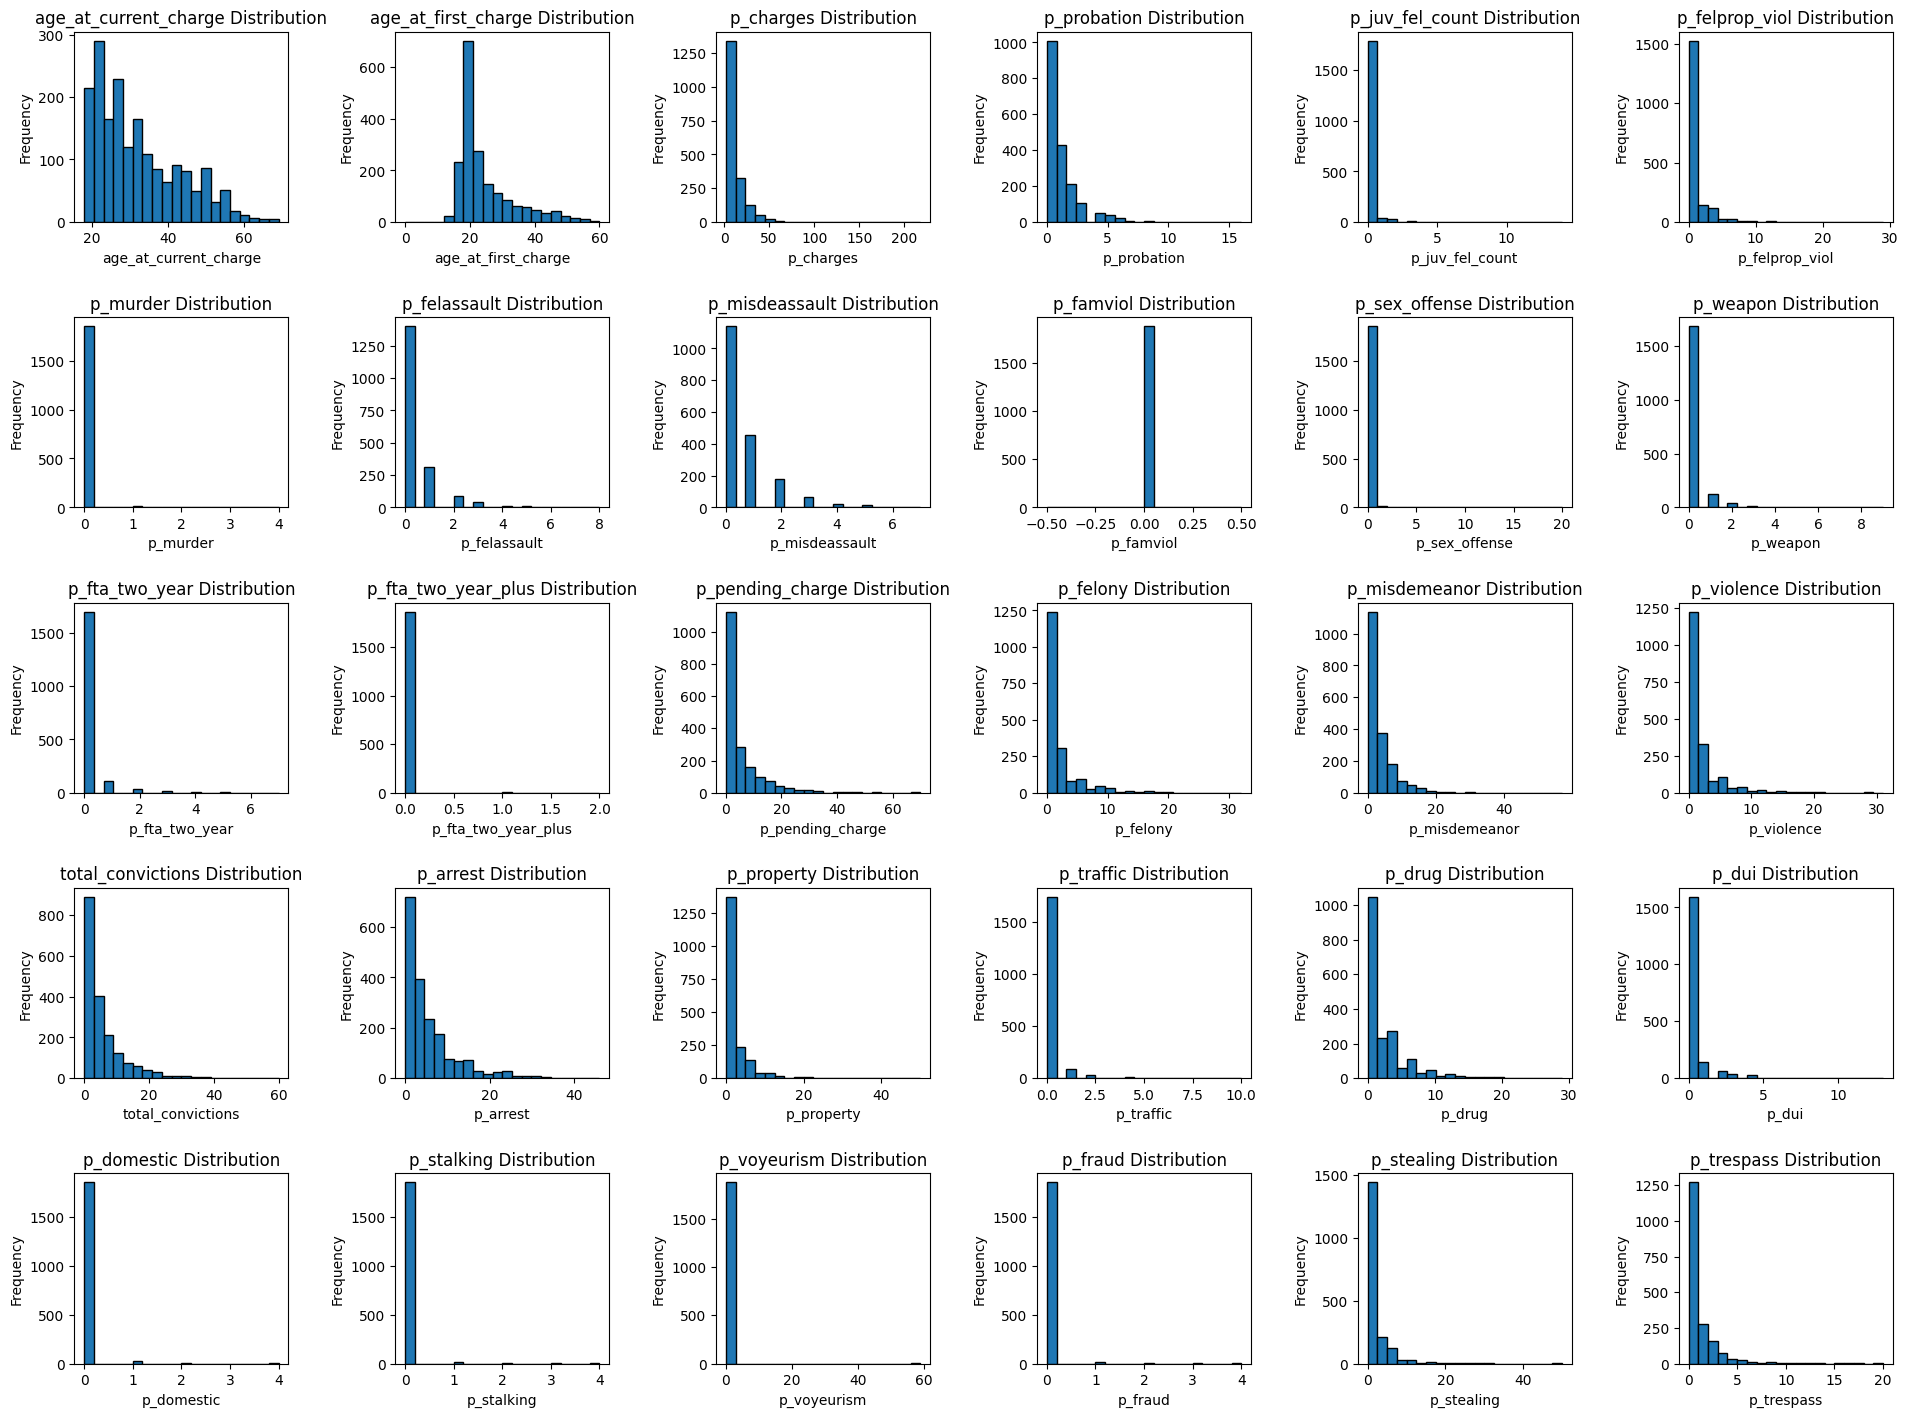

In [113]:
### HISTOGRAMS ###
# to show distribution of data
# features that could possibly be represented with one:
numerical_features = ['age_at_current_charge','age_at_first_charge','p_charges',
                      'p_probation','p_juv_fel_count','p_felprop_viol','p_murder',
                      'p_felassault','p_misdeassault','p_famviol','p_sex_offense',
                      'p_weapon','p_fta_two_year','p_fta_two_year_plus',
                      'p_pending_charge','p_felony','p_misdemeanor','p_violence',
                      'total_convictions','p_arrest','p_property','p_traffic','p_drug',
                      'p_dui','p_domestic','p_stalking','p_voyeurism','p_fraud',
                      'p_stealing','p_trespass']

# display details
rows = 5
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.tight_layout(pad=5.0)

# loop through features
for i, feature in enumerate(numerical_features):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.hist(dataset[feature], bins=20, edgecolor='black')
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

# display
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()




In [114]:
# it appears that the variance of feature 'p_famviol' is zero. confirm this:
if dataset['p_famviol'].max() == dataset['p_famviol'].min():
    print("yeah they're all the same")
else: 
    print("nah")

yeah they're all the same


Clean:

In [115]:
cleaned_data = cleaned_data.drop('p_famviol', axis=1)
features.remove('p_famviol')
numerical_features.remove('p_famviol')

##### Scatter plots

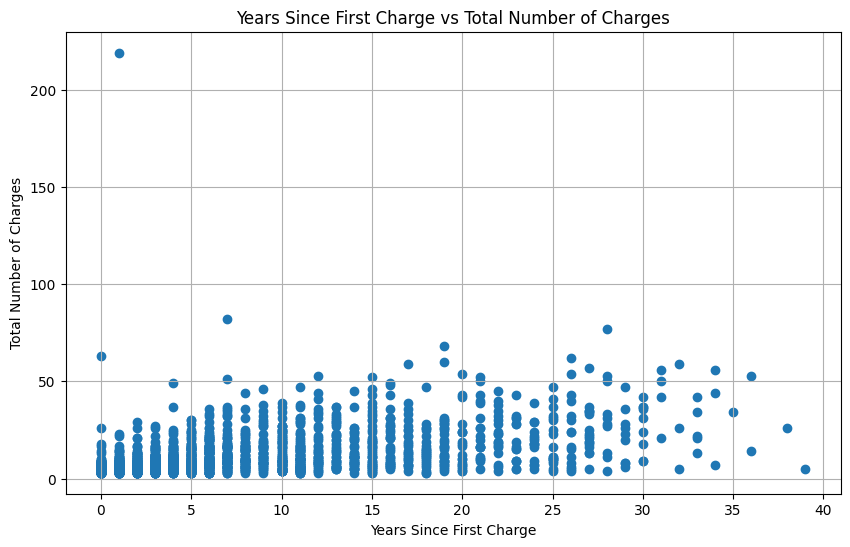

In [116]:
### SCATTER PLOTS ###
# to show relationships between features/targets

# years since first charge vs number of past charges
years_elapsed = dataset['age_at_current_charge'] - dataset['age_at_first_charge']
total_charges = dataset['p_charges'] + 1

plt.figure(figsize=(10, 6))
plt.scatter(years_elapsed, total_charges)
plt.title('Years Since First Charge vs Total Number of Charges')
plt.xlabel('Years Since First Charge')
plt.ylabel('Total Number of Charges')
plt.grid(True)
plt.show()

**Split into test and training**

In [117]:
X = cleaned_data[features]   # feature values for all rows in cleaned dataset
y = cleaned_data[targets]    # target values for all rows in cleaned dataset

### SPLIT INTO TRAIN AND TEST SETS ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standardize**

In [119]:
#scale training set, then use the same variables to scale the test set
scaler = StandardScaler()
train_std = X_train
train_std[numerical_features] = scaler.fit_transform(train_std[numerical_features])
test_std = X_test
test_std[numerical_features] = scaler.fit_transform(test_std[numerical_features])


In [ ]:
### ROC CURVES ###


### DIMENSIONALITY REDUCTION ###


### CLUSTERING ALGORITHMS ###